In [100]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split


TODO:
1. Early Stopping
2. Fixing 3d functions

In [101]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU jest dostępna.")
else:
    device = torch.device("cpu")
    print("GPU nie jest dostępna, używam CPU.")

GPU jest dostępna.




---



https://machinelearningmastery.com/difference-test-validation-datasets/

Helper functions

In [102]:
def rastrigin(x, y):
    return 20 + (x**2 - 10 * np.cos(2*np.pi*x)) + (y**2 - 10 * np.cos(2*np.pi*y))

def ackley(x, y):
    return -20 * np.exp(-0.2 * np.sqrt(0.5*(x**2 + y**2))) - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + 20 + np.e

def booth(x, y):
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2

In [103]:
def plot_func_2D(x, y, name):
  plt.plot(x, y)
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(f'{name}')
  plt.grid(True)
  plt.show()

In [104]:
def plot_func_3D(X, Y, Z, title):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [105]:
def prepare_datasets(y_values, flag, sequence_length=1000):
  X = []
  y = []
  for i in range(len(y_values) - sequence_length):
      X.append(y_values[i:i+sequence_length])
      y.append(y_values[i+sequence_length])
  if flag == "RNN":
    X = torch.tensor(X).unsqueeze(2).float()
  elif flag == "CNN":
    X = torch.tensor(X).unsqueeze(1).float()
  y = torch.tensor(y).unsqueeze(1).float()
  split = int(0.8 * len(X))
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  return X_train, X_test, y_train, y_test

In [106]:
def prepare_datasets_2D(X_values, Y_values, Z_values, flag, sequence_length=1000):
    X = []
    y = []
    X_values = X_values.flatten()
    Y_values = Y_values.flatten()
    Z_values = Z_values.flatten()
    for i in range(len(Z_values) - sequence_length):
        input_sequence = np.stack((X_values[i:i+sequence_length], Y_values[i:i+sequence_length]), axis=1)
        X.append(input_sequence)
        y.append(Z_values[i+sequence_length])

    # if flag == "RNN":
    #     X = torch.tensor(X).float()
    # elif flag == "CNN":
    #     X = torch.tensor(X).permute(0, 2, 1).float()
    
    X = torch.tensor(X).float()
    y = torch.tensor(y).unsqueeze(1).float()

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, X_test, y_train, y_test

In [107]:
def training_n_evaluation(name, epochs, model, criterion, optimizer, X_train, X_test, y_train, y_test):
  for epoch in range(epochs):
      model.train()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

  model.eval()
  with torch.no_grad():
      test_predictions = model(X_test)

  plt.plot(y_test.numpy(), label='True')
  plt.title(f'{name}: True vs Predicted')
  plt.plot(test_predictions.numpy(), label='Predicted')
  plt.legend()
  plt.show()

In [108]:
def training_n_evaluation_3D(name, epochs, model, criterion, optimizer, X_train, X_test, y_train, y_test):

    for epoch in range(epochs):
        model.train()
        if name == "CNN":
            outputs = model(X_train.transpose(1, 2))
        else:
            outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test)

    X_test_3D = X_test[:, 0].unsqueeze(1)  
    Y_test_3D = X_test[:, 1].unsqueeze(1) 
    Z_test_3D = test_predictions.unsqueeze(1)  

    Z_test_2D = Z_test_3D.squeeze().reshape(X_test_3D.shape[0], -1)

    plot_func_3D(X_test_3D.squeeze(), Y_test_3D.squeeze(), Z_test_2D, "Test Predictions")

Neural Networks Architectures

In [179]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class SimpleCNN(nn.Module):
    def __init__(self, sequence_length, input_size=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)        
        self.fc1 = nn.Linear(32 * sequence_length, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
#         print("Shape after conv1:", x.shape)
        x = torch.relu(self.conv2(x))
#         print("Shape after conv2:", x.shape)
        x = x.view(x.size(0), -1)
#         print("Shape after flattening:", x.shape)
        x = torch.relu(self.fc1(x))
#         print("Shape after fc1:", x.shape)
        x = self.fc2(x)
#         print("Shape after fc2:", x.shape)
        return x

Models

sin(x)

In [110]:
def gen_sin(total_samples, lessen_values):
  x = np.arange(0, total_samples)
  sin_y = np.sin(lessen_values * x)
  return sin_y

Epoch [1/10], Loss: 0.4572
Epoch [2/10], Loss: 0.4403
Epoch [3/10], Loss: 0.4238
Epoch [4/10], Loss: 0.4075
Epoch [5/10], Loss: 0.3915
Epoch [6/10], Loss: 0.3757
Epoch [7/10], Loss: 0.3598
Epoch [8/10], Loss: 0.3438
Epoch [9/10], Loss: 0.3275
Epoch [10/10], Loss: 0.3107


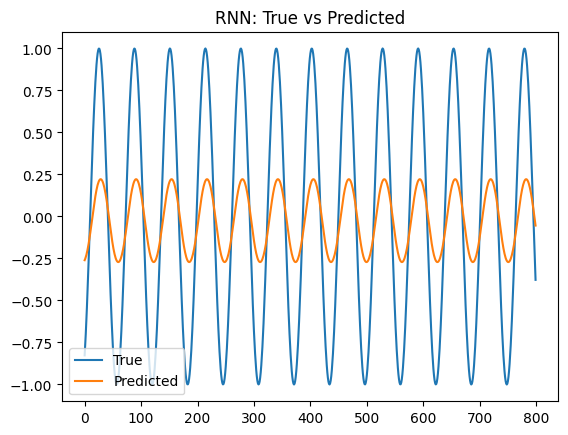

Epoch [1/10], Loss: 0.4828
Epoch [2/10], Loss: 0.9761
Epoch [3/10], Loss: 0.7017
Epoch [4/10], Loss: 1.7793
Epoch [5/10], Loss: 0.3493
Epoch [6/10], Loss: 0.4564
Epoch [7/10], Loss: 0.4352
Epoch [8/10], Loss: 0.3767
Epoch [9/10], Loss: 0.5047
Epoch [10/10], Loss: 0.2322


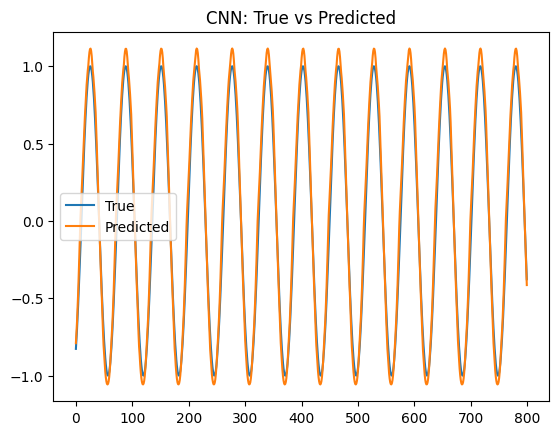

In [115]:
sin_y = gen_sin(5000, lessen_values=0.1)

X_train_RNN_sin_y, X_test_RNN_sin_y, y_train_RNN_sin_y, y_test_RNN_sin_y = prepare_datasets(sin_y, "RNN")
X_train_CNN_sin_y, X_test_CNN_sin_y, y_train_CNN_sin_y, y_test_CNN_sin_y = prepare_datasets(sin_y, "CNN")

model_RNN_sin = SimpleRNN(input_size=1, hidden_size=32, output_size=1)
criterion_RNN_sin = nn.MSELoss()
optimizer_RNN_sin = torch.optim.Adam(model_RNN_sin.parameters(), lr=0.001)
training_n_evaluation("RNN", 10, model_RNN_sin, criterion_RNN_sin, optimizer_RNN_sin, X_train_RNN_sin_y, X_test_RNN_sin_y, y_train_RNN_sin_y, y_test_RNN_sin_y)

model_CNN_sin = SimpleCNN(sequence_length=1000)
criterion_CNN_sin = nn.MSELoss()
optimizer_CNN_sin = torch.optim.Adam(model_CNN_sin.parameters(), lr=0.001)
training_n_evaluation("CNN", 10, model_CNN_sin, criterion_CNN_sin, optimizer_CNN_sin, X_train_CNN_sin_y, X_test_CNN_sin_y, y_train_CNN_sin_y, y_test_CNN_sin_y)

sin(x) * cos(x)

In [116]:
def gen_sin_cos(total_samples, lessen_values):
  x = np.arange(0, total_samples)
  sin_cos_y = np.sin(lessen_values * x) * np.cos(lessen_values * x)
  return sin_cos_y

Epoch [1/10], Loss: 0.1289
Epoch [2/10], Loss: 0.1240
Epoch [3/10], Loss: 0.1198
Epoch [4/10], Loss: 0.1160
Epoch [5/10], Loss: 0.1127
Epoch [6/10], Loss: 0.1097
Epoch [7/10], Loss: 0.1070
Epoch [8/10], Loss: 0.1044
Epoch [9/10], Loss: 0.1019
Epoch [10/10], Loss: 0.0993


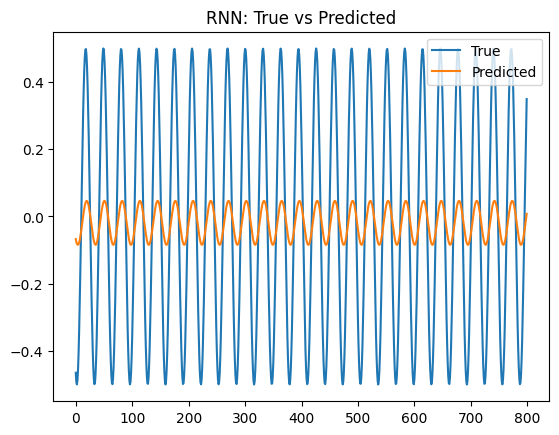

Epoch [1/10], Loss: 0.1212
Epoch [2/10], Loss: 2.0183
Epoch [3/10], Loss: 2.7775
Epoch [4/10], Loss: 1.3023
Epoch [5/10], Loss: 0.1295
Epoch [6/10], Loss: 0.1746
Epoch [7/10], Loss: 0.5569
Epoch [8/10], Loss: 0.6036
Epoch [9/10], Loss: 0.3952
Epoch [10/10], Loss: 0.1567


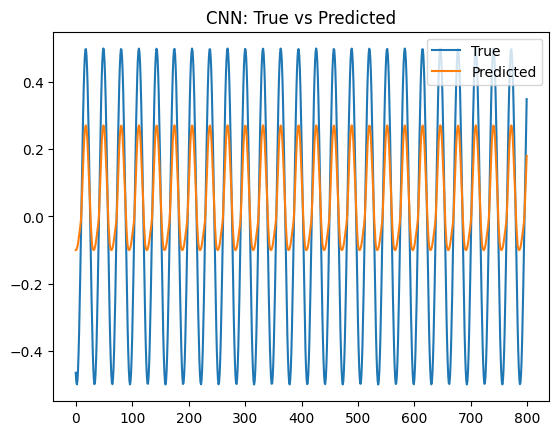

In [117]:
sin_cos_y = gen_sin_cos(5000, lessen_values=0.1)

X_train_RNN_sin_cos_y, X_test_RNN_sin_cos_y, y_train_RNN_sin_cos_y, y_test_RNN_sin_cos_y = prepare_datasets(sin_cos_y, "RNN")
X_train_CNN_sin_cos_y, X_test_CNN_sin_cos_y, y_train_CNN_sin_cos_y, y_test_CNN_sin_cos_y = prepare_datasets(sin_cos_y, "CNN")

model_RNN_sin_cos = SimpleRNN(input_size=1, hidden_size=32, output_size=1)
criterion_RNN_sin_cos = nn.MSELoss()
optimizer_RNN_sin_cos = torch.optim.Adam(model_RNN_sin_cos.parameters(), lr=0.001)
training_n_evaluation("RNN", 10, model_RNN_sin_cos, criterion_RNN_sin_cos, optimizer_RNN_sin_cos, X_train_RNN_sin_cos_y, X_test_RNN_sin_cos_y, y_train_RNN_sin_cos_y, y_test_RNN_sin_cos_y)

model_CNN_sin_cos = SimpleCNN(sequence_length=1000)
criterion_CNN_sin_cos = nn.MSELoss()
optimizer_CNN_sin_cos = torch.optim.Adam(model_CNN_sin_cos.parameters(), lr=0.001)
training_n_evaluation("CNN", 10, model_CNN_sin_cos, criterion_CNN_sin_cos, optimizer_CNN_sin_cos, X_train_CNN_sin_cos_y, X_test_CNN_sin_cos_y, y_train_CNN_sin_cos_y, y_test_CNN_sin_cos_y)

sin(2*x)

In [118]:
def gen_sin2(total_samples, lessen_values):
  x = np.arange(0, total_samples)
  sin_y = np.sin(2* lessen_values * x)
  return sin_y

Epoch [1/10], Loss: 0.5797
Epoch [2/10], Loss: 0.5609
Epoch [3/10], Loss: 0.5428
Epoch [4/10], Loss: 0.5255
Epoch [5/10], Loss: 0.5088
Epoch [6/10], Loss: 0.4927
Epoch [7/10], Loss: 0.4772
Epoch [8/10], Loss: 0.4623
Epoch [9/10], Loss: 0.4477
Epoch [10/10], Loss: 0.4336


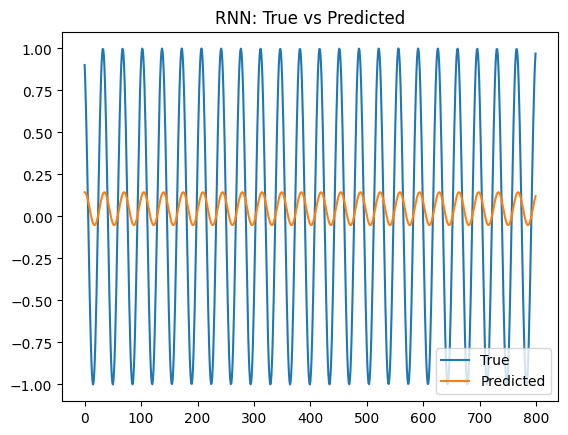

Epoch [1/10], Loss: 0.5222
Epoch [2/10], Loss: 0.5413
Epoch [3/10], Loss: 1.2113
Epoch [4/10], Loss: 0.2977
Epoch [5/10], Loss: 0.0788
Epoch [6/10], Loss: 0.2851
Epoch [7/10], Loss: 0.3699
Epoch [8/10], Loss: 0.2963
Epoch [9/10], Loss: 0.1668
Epoch [10/10], Loss: 0.0606


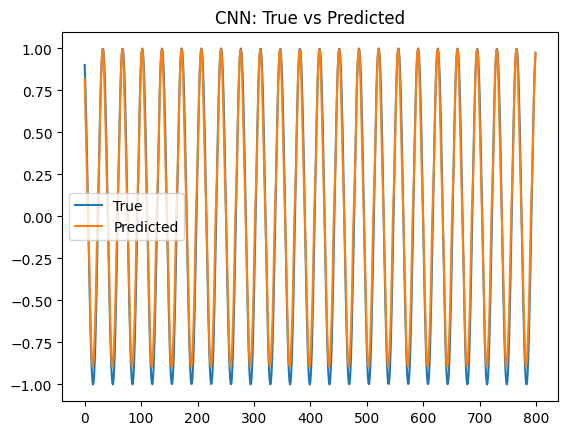

In [120]:
sin2_y = gen_sin2(5000, lessen_values=0.09)

X_train_RNN_sin2_y, X_test_RNN_sin2_y , y_train_RNN_sin2_y, y_test_RNN_sin2_y = prepare_datasets(sin2_y, "RNN")
X_train_CNN_sin2_y, X_test_CNN_sin2_y , y_train_CNN_sin2_y, y_test_CNN_sin2_y = prepare_datasets(sin2_y, "CNN")

model_RNN_sin2_y = SimpleRNN(input_size=1, hidden_size=32, output_size=1)
criterion_RNN_sin2_y  = nn.MSELoss()
optimizer_RNN_sin2_y  = torch.optim.Adam(model_RNN_sin2_y.parameters(), lr=0.001)
training_n_evaluation("RNN", 10, model_RNN_sin2_y, criterion_RNN_sin2_y, optimizer_RNN_sin2_y, X_train_RNN_sin2_y, X_test_RNN_sin2_y, y_train_RNN_sin2_y, y_test_RNN_sin2_y)

model_CNN_sin2_y = SimpleCNN(sequence_length=1000)
criterion_CNN_sin2_y  = nn.MSELoss()
optimizer_CNN_sin2_y  = torch.optim.Adam(model_CNN_sin2_y.parameters(), lr=0.001)
training_n_evaluation("CNN", 10, model_CNN_sin2_y, criterion_CNN_sin2_y, optimizer_CNN_sin2_y, X_train_CNN_sin2_y, X_test_CNN_sin2_y, y_train_CNN_sin2_y, y_test_CNN_sin2_y)

(sin(3*x))**2 + cos(2*x)

In [121]:
def gen_sin3_plus_cos22(total_samples, lessen_values):
  x = np.arange(0, total_samples)
  sin3_cos22_y = ((np.sin(3 * lessen_values * x)) ** 2) + np.cos(2* lessen_values * x)
  return sin3_cos22_y

Epoch [1/10], Loss: 0.6748
Epoch [2/10], Loss: 0.6547
Epoch [3/10], Loss: 0.6359
Epoch [4/10], Loss: 0.6185
Epoch [5/10], Loss: 0.6027
Epoch [6/10], Loss: 0.5883
Epoch [7/10], Loss: 0.5756
Epoch [8/10], Loss: 0.5645
Epoch [9/10], Loss: 0.5551
Epoch [10/10], Loss: 0.5473


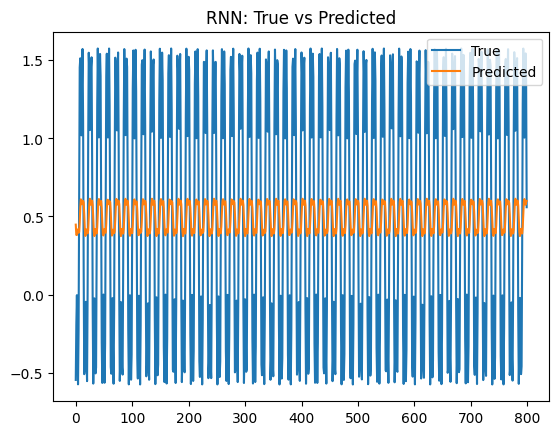

Epoch [1/10], Loss: 0.9468
Epoch [2/10], Loss: 9.2026
Epoch [3/10], Loss: 1.2039
Epoch [4/10], Loss: 5.5738
Epoch [5/10], Loss: 3.4937
Epoch [6/10], Loss: 0.6154
Epoch [7/10], Loss: 0.2147
Epoch [8/10], Loss: 1.4751
Epoch [9/10], Loss: 2.0527
Epoch [10/10], Loss: 1.4224


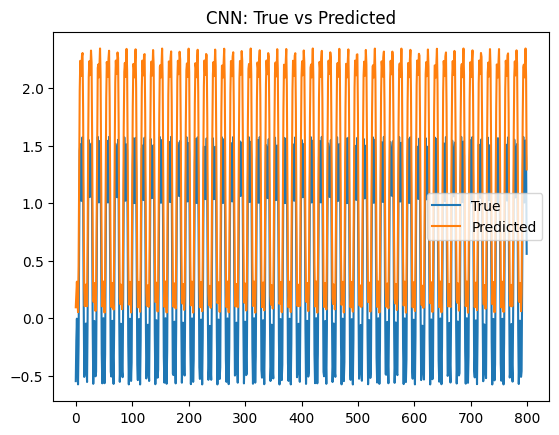

In [122]:
sin3_plus_cos22_y = gen_sin3_plus_cos22(5000, lessen_values=0.2)

X_train_RNN_sin3_plus_cos22_y, X_test_RNN_sin3_plus_cos22_y, y_train_RNN_sin3_plus_cos22_y, y_test_RNN_sin3_plus_cos22_y = prepare_datasets(sin3_plus_cos22_y, "RNN")
X_train_CNN_sin3_plus_cos22_y, X_test_CNN_sin3_plus_cos22_y, y_train_CNN_sin3_plus_cos22_y, y_test_CNN_sin3_plus_cos22_y = prepare_datasets(sin3_plus_cos22_y, "CNN")

model_RNN_sin3_plus_cos22 = SimpleRNN(input_size=1, hidden_size=32, output_size=1)
criterion_RNN_sin3_plus_cos2 = nn.MSELoss()
optimizer_RNN_sin3_plus_cos2 = torch.optim.Adam(model_RNN_sin3_plus_cos22.parameters(), lr=0.001)
training_n_evaluation("RNN", 10, model_RNN_sin3_plus_cos22, criterion_RNN_sin3_plus_cos2, optimizer_RNN_sin3_plus_cos2, X_train_RNN_sin3_plus_cos22_y, X_test_RNN_sin3_plus_cos22_y, y_train_RNN_sin3_plus_cos22_y, y_test_RNN_sin3_plus_cos22_y)

model_CNN_sin3_plus_cos22 = SimpleCNN(sequence_length=1000)
criterion_CNN_sin3_plus_cos2 = nn.MSELoss()
optimizer_CNN_sin3_plus_cos2 = torch.optim.Adam(model_CNN_sin3_plus_cos22.parameters(), lr=0.001)
training_n_evaluation("CNN", 10, model_CNN_sin3_plus_cos22, criterion_CNN_sin3_plus_cos2, optimizer_CNN_sin3_plus_cos2, X_train_CNN_sin3_plus_cos22_y, X_test_CNN_sin3_plus_cos22_y, y_train_CNN_sin3_plus_cos22_y, y_test_CNN_sin3_plus_cos22_y)


f(x)
rastrigin

In [141]:
def rastragin_2d_slice():
    A = 10.0
    x_values = np.linspace(-5.12, 5.12, 5000)
    y_values = []
    for x in x_values:
        delta = x**2 - A * np.cos(2 * np.pi * x)
        y = A + delta
        y_values.append(y)
    return x_values, y_values

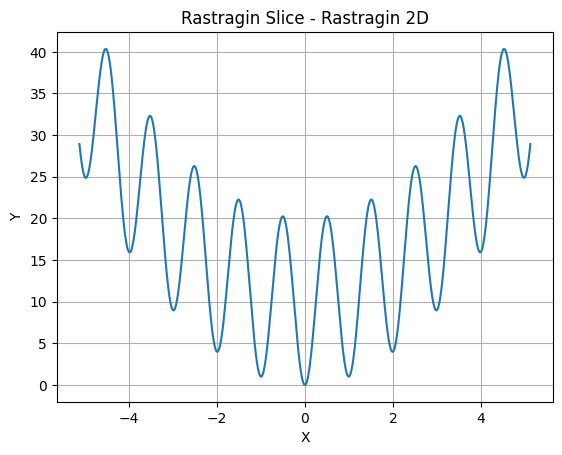

Epoch [1/150], Loss: 368.6877
Epoch [2/150], Loss: 219.2911
Epoch [3/150], Loss: 82.3916
Epoch [4/150], Loss: 445.1242
Epoch [5/150], Loss: 102.0251
Epoch [6/150], Loss: 94.6614
Epoch [7/150], Loss: 69.3769
Epoch [8/150], Loss: 61.5368
Epoch [9/150], Loss: 46.9192
Epoch [10/150], Loss: 42.0685
Epoch [11/150], Loss: 36.6512
Epoch [12/150], Loss: 32.5676
Epoch [13/150], Loss: 27.6464
Epoch [14/150], Loss: 24.7569
Epoch [15/150], Loss: 21.4678
Epoch [16/150], Loss: 17.4397
Epoch [17/150], Loss: 14.3106
Epoch [18/150], Loss: 11.4780
Epoch [19/150], Loss: 9.4910
Epoch [20/150], Loss: 8.1214
Epoch [21/150], Loss: 7.9136
Epoch [22/150], Loss: 6.2343
Epoch [23/150], Loss: 5.9917
Epoch [24/150], Loss: 4.5550
Epoch [25/150], Loss: 4.1646
Epoch [26/150], Loss: 3.0369
Epoch [27/150], Loss: 2.6179
Epoch [28/150], Loss: 1.8644
Epoch [29/150], Loss: 1.4970
Epoch [30/150], Loss: 1.4239
Epoch [31/150], Loss: 0.9490
Epoch [32/150], Loss: 1.0885
Epoch [33/150], Loss: 0.7859
Epoch [34/150], Loss: 0.8816
E

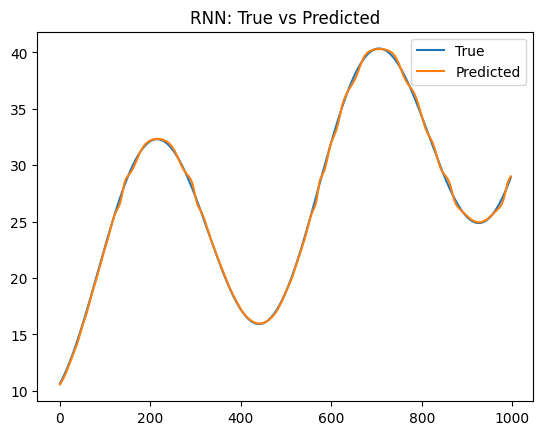

Epoch [1/150], Loss: 363.4503
Epoch [2/150], Loss: 2207299.5000
Epoch [3/150], Loss: 9872.6992
Epoch [4/150], Loss: 4450.9995
Epoch [5/150], Loss: 263.4532
Epoch [6/150], Loss: 2069.2471
Epoch [7/150], Loss: 1795.1140
Epoch [8/150], Loss: 1054.3401
Epoch [9/150], Loss: 465.9745
Epoch [10/150], Loss: 83.9217
Epoch [11/150], Loss: 40.7650
Epoch [12/150], Loss: 107.2204
Epoch [13/150], Loss: 77.8409
Epoch [14/150], Loss: 10.2368
Epoch [15/150], Loss: 49.0454
Epoch [16/150], Loss: 12.2016
Epoch [17/150], Loss: 5.7018
Epoch [18/150], Loss: 20.4446
Epoch [19/150], Loss: 14.8238
Epoch [20/150], Loss: 3.3922
Epoch [21/150], Loss: 4.6978
Epoch [22/150], Loss: 15.1678
Epoch [23/150], Loss: 21.6002
Epoch [24/150], Loss: 21.5838
Epoch [25/150], Loss: 19.8468
Epoch [26/150], Loss: 19.7095
Epoch [27/150], Loss: 22.1723
Epoch [28/150], Loss: 27.3899
Epoch [29/150], Loss: 35.2515
Epoch [30/150], Loss: 45.2059
Epoch [31/150], Loss: 56.0125
Epoch [32/150], Loss: 65.6796
Epoch [33/150], Loss: 72.0202
Epo

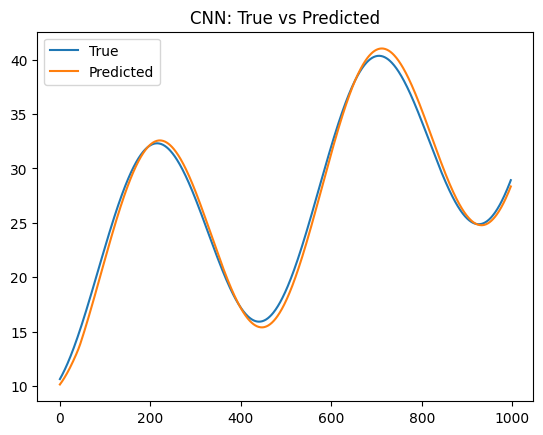

In [152]:
ras_x, ras_y = rastragin_2d_slice()
plot_func_2D(ras_x, ras_y, "Rastragin Slice - Rastragin 2D")

X_train_RNN_ras, X_test_RNN_ras, y_train_RNN_ras, y_test_RNN_ras = prepare_datasets(ras_y, "RNN", sequence_length=10)
X_train_CNN_ras, X_test_CNN_ras, y_train_CNN_ras, y_test_CNN_ras = prepare_datasets(ras_y, "CNN", sequence_length=10)

model_RNN_ras = SimpleRNN(input_size=1, hidden_size=128, output_size=1)
criterion_RNN_ras = nn.MSELoss()
optimizer_RNN_ras = torch.optim.Adam(model_RNN_ras.parameters(), lr=0.1)
training_n_evaluation("RNN", 150, model_RNN_ras, criterion_RNN_ras, optimizer_RNN_ras, X_train_RNN_ras, X_test_RNN_ras, y_train_RNN_ras, y_test_RNN_ras)

model_CNN_ras = SimpleCNN(sequence_length=10)
criterion_CNN_ras = nn.MSELoss()
optimizer_CNN_ras = torch.optim.Adam(model_CNN_ras.parameters(), lr=0.1)
training_n_evaluation("CNN", 150, model_CNN_ras, criterion_CNN_ras, optimizer_CNN_ras, X_train_CNN_ras, X_test_CNN_ras, y_train_CNN_ras, y_test_CNN_ras)

f(x)
ackley

In [153]:
def ackley_2d_slice():
    a = 20
    b = 0.2
    c = 2 * np.pi
    n = 2

    x_values = np.linspace(-5, 5, 5000)
    y_values = (-a * np.exp(-b * np.sqrt(x_values**2 / n))
                - np.exp((np.cos(c * x_values) + np.cos(c * x_values)) / n)
                + a + np.exp(1))

    return x_values, y_values

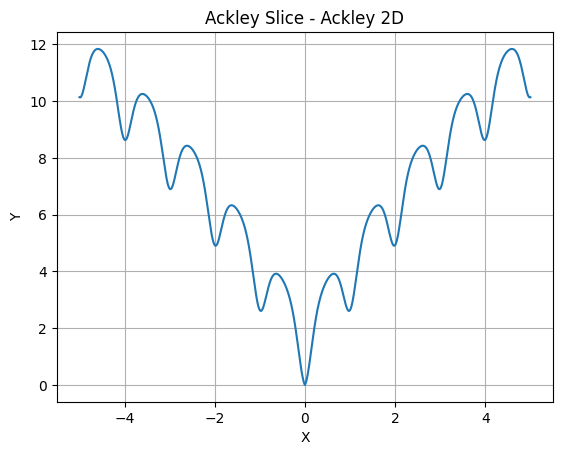

Epoch [1/300], Loss: 43.0678
Epoch [2/300], Loss: 36.8178
Epoch [3/300], Loss: 32.0586
Epoch [4/300], Loss: 28.1472
Epoch [5/300], Loss: 24.8270
Epoch [6/300], Loss: 22.0081
Epoch [7/300], Loss: 19.6009
Epoch [8/300], Loss: 17.5248
Epoch [9/300], Loss: 15.7295
Epoch [10/300], Loss: 14.1808
Epoch [11/300], Loss: 12.8511
Epoch [12/300], Loss: 11.7198
Epoch [13/300], Loss: 10.7727
Epoch [14/300], Loss: 9.9987
Epoch [15/300], Loss: 9.3873
Epoch [16/300], Loss: 8.9273
Epoch [17/300], Loss: 8.6056
Epoch [18/300], Loss: 8.4061
Epoch [19/300], Loss: 8.3107
Epoch [20/300], Loss: 8.2995
Epoch [21/300], Loss: 8.3519
Epoch [22/300], Loss: 8.4469
Epoch [23/300], Loss: 8.5642
Epoch [24/300], Loss: 8.6854
Epoch [25/300], Loss: 8.7939
Epoch [26/300], Loss: 8.8759
Epoch [27/300], Loss: 8.9202
Epoch [28/300], Loss: 8.9168
Epoch [29/300], Loss: 8.8566
Epoch [30/300], Loss: 8.7326
Epoch [31/300], Loss: 8.5452
Epoch [32/300], Loss: 8.3068
Epoch [33/300], Loss: 8.0343
Epoch [34/300], Loss: 7.7398
Epoch [35/

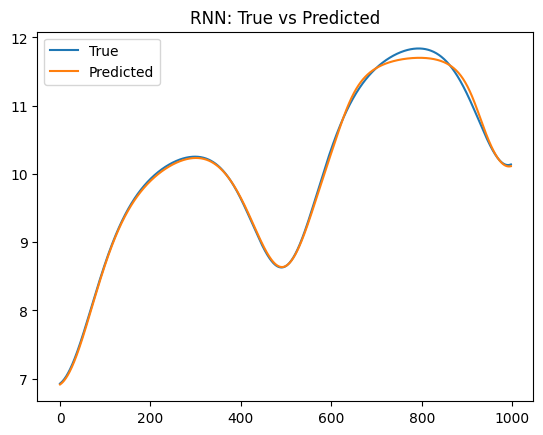

Epoch [1/250], Loss: 54.1928
Epoch [2/250], Loss: 22802.0410
Epoch [3/250], Loss: 109.9087
Epoch [4/250], Loss: 54.6348
Epoch [5/250], Loss: 51.8136
Epoch [6/250], Loss: 52.0151
Epoch [7/250], Loss: 51.8461
Epoch [8/250], Loss: 51.2973
Epoch [9/250], Loss: 50.3993
Epoch [10/250], Loss: 98.5584
Epoch [11/250], Loss: 47.5561
Epoch [12/250], Loss: 45.6239
Epoch [13/250], Loss: 43.3827
Epoch [14/250], Loss: 40.8771
Epoch [15/250], Loss: 38.3129
Epoch [16/250], Loss: 35.6101
Epoch [17/250], Loss: 32.6701
Epoch [18/250], Loss: 29.5194
Epoch [19/250], Loss: 26.0170
Epoch [20/250], Loss: 21.4164
Epoch [21/250], Loss: 15.8510
Epoch [22/250], Loss: 10.1714
Epoch [23/250], Loss: 7.2347
Epoch [24/250], Loss: 11.3330
Epoch [25/250], Loss: 13.3586
Epoch [26/250], Loss: 11.0754
Epoch [27/250], Loss: 8.2851
Epoch [28/250], Loss: 6.9339
Epoch [29/250], Loss: 6.8033
Epoch [30/250], Loss: 7.1447
Epoch [31/250], Loss: 7.4301
Epoch [32/250], Loss: 7.4980
Epoch [33/250], Loss: 7.3817
Epoch [34/250], Loss: 7

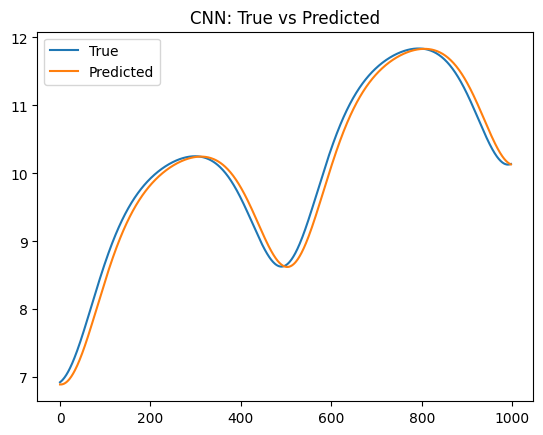

In [162]:
ack_x, ack_y = ackley_2d_slice()
plot_func_2D(ack_x, ack_y, "Ackley Slice - Ackley 2D")

X_train_RNN_ack, X_test_RNN_ack, y_train_RNN_ack, y_test_RNN_ack = prepare_datasets(ack_y, "RNN", sequence_length=10)
X_train_CNN_ras, X_test_CNN_ras, y_train_CNN_ras, y_test_CNN_ras = prepare_datasets(ack_y, "CNN", sequence_length=12)

model_RNN_ack = SimpleRNN(input_size=1, hidden_size=32, output_size=1)
criterion_RNN_ack = nn.MSELoss()
optimizer_RNN_ack = torch.optim.Adam(model_RNN_ack.parameters(), lr=0.01)
training_n_evaluation("RNN", 300, model_RNN_ack, criterion_RNN_ack, optimizer_RNN_ack, X_train_RNN_ack, X_test_RNN_ack, y_train_RNN_ack, y_test_RNN_ack)

model_CNN_ras = SimpleCNN(sequence_length=12)
criterion_CNN_ras = nn.MSELoss()
optimizer_CNN_ras = torch.optim.Adam(model_CNN_ras.parameters(), lr=0.1)
training_n_evaluation("CNN", 250, model_CNN_ras, criterion_CNN_ras, optimizer_CNN_ras, X_train_CNN_ras, X_test_CNN_ras, y_train_CNN_ras, y_test_CNN_ras)


f(x) rosenbrock

In [180]:
def rosenbrock_2d_slice():
    x_values = np.linspace(-5, 5, 5000)
    y_values = ((100 * (x_values - (x_values)**2))**2) + ((1 - x_values)**2)
    return x_values, y_values

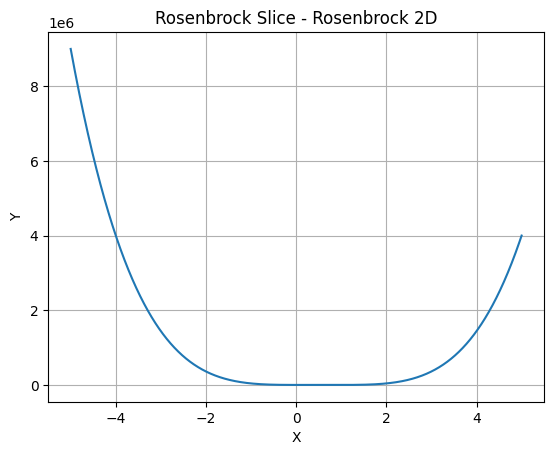

Epoch [1/100], Loss: 6067847692288.0000
Epoch [2/100], Loss: 6067847692288.0000
Epoch [3/100], Loss: 6067847692288.0000
Epoch [4/100], Loss: 6067847692288.0000
Epoch [5/100], Loss: 6067847692288.0000
Epoch [6/100], Loss: 6067847692288.0000
Epoch [7/100], Loss: 6067847692288.0000
Epoch [8/100], Loss: 6067847692288.0000
Epoch [9/100], Loss: 6067847692288.0000
Epoch [10/100], Loss: 6067847692288.0000
Epoch [11/100], Loss: 6067847692288.0000
Epoch [12/100], Loss: 6067847692288.0000
Epoch [13/100], Loss: 6067847692288.0000
Epoch [14/100], Loss: 6067847692288.0000
Epoch [15/100], Loss: 6067847692288.0000
Epoch [16/100], Loss: 6067847692288.0000
Epoch [17/100], Loss: 6067847692288.0000
Epoch [18/100], Loss: 6067847168000.0000
Epoch [19/100], Loss: 6067846119424.0000
Epoch [20/100], Loss: 6067846119424.0000
Epoch [21/100], Loss: 6067846119424.0000
Epoch [22/100], Loss: 6067846119424.0000
Epoch [23/100], Loss: 6067846119424.0000
Epoch [24/100], Loss: 6067846119424.0000
Epoch [25/100], Loss: 606

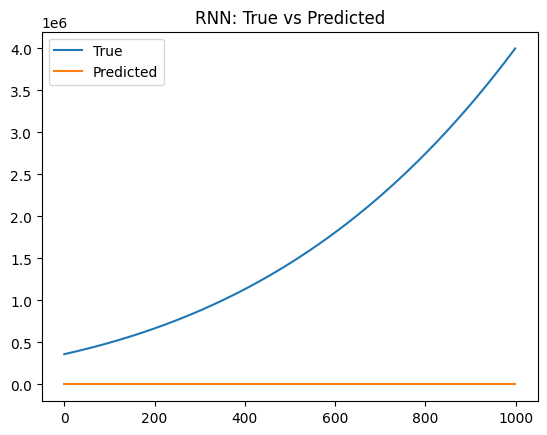

Epoch [1/100], Loss: 5878645260288.0000
Epoch [2/100], Loss: 9639864043569152.0000
Epoch [3/100], Loss: 6769092329472.0000
Epoch [4/100], Loss: 5963627102208.0000
Epoch [5/100], Loss: 9921598849024.0000
Epoch [6/100], Loss: 22963065716736.0000
Epoch [7/100], Loss: 21174295724032.0000
Epoch [8/100], Loss: 9510215221248.0000
Epoch [9/100], Loss: 6033932025856.0000
Epoch [10/100], Loss: 5923314597888.0000
Epoch [11/100], Loss: 5905154310144.0000
Epoch [12/100], Loss: 5624287985664.0000
Epoch [13/100], Loss: 5062394380288.0000
Epoch [14/100], Loss: 4114457034752.0000
Epoch [15/100], Loss: 2775698112512.0000
Epoch [16/100], Loss: 1307497857024.0000
Epoch [17/100], Loss: 153871826944.0000
Epoch [18/100], Loss: 365034930176.0000
Epoch [19/100], Loss: 1722091962368.0000
Epoch [20/100], Loss: 1557608267776.0000
Epoch [21/100], Loss: 599641030656.0000
Epoch [22/100], Loss: 41064820736.0000
Epoch [23/100], Loss: 81610825728.0000
Epoch [24/100], Loss: 394290298880.0000
Epoch [25/100], Loss: 705030

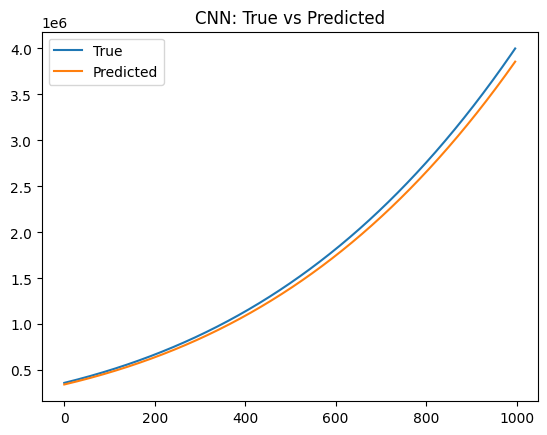

In [182]:
rosen_x, rosen_y = rosenbrock_2d_slice()
plot_func_2D(rosen_x, rosen_y, "Rosenbrock Slice - Rosenbrock 2D")

X_train_RNN_rosen, X_test_RNN_rosen, y_train_RNN_rosen, y_test_RNN_rosen = prepare_datasets(rosen_y, "RNN", sequence_length=4)
X_train_CNN_rosen, X_test_CNN_rosen, y_train_CNN_rosen, y_test_CNN_rosen = prepare_datasets(rosen_y, "CNN", sequence_length=10)

model_RNN_rosen = SimpleRNN(input_size=1, hidden_size=32, output_size=1)
criterion_RNN_rosen = nn.MSELoss()
optimizer_RNN_rosen = torch.optim.Adam(model_RNN_rosen.parameters(), lr=0.001)
training_n_evaluation("RNN", 100, model_RNN_rosen, criterion_RNN_rosen, optimizer_RNN_rosen, X_train_RNN_rosen, X_test_RNN_rosen, y_train_RNN_rosen, y_test_RNN_rosen)

model_CNN_rosen = SimpleCNN(sequence_length=10)
criterion_CNN_rosen = nn.MSELoss()
optimizer_CNN_rosen = torch.optim.Adam(model_CNN_rosen.parameters(), lr=0.1)
training_n_evaluation("CNN", 100, model_CNN_rosen, criterion_CNN_rosen, optimizer_CNN_rosen, X_train_CNN_rosen, X_test_CNN_rosen, y_train_CNN_rosen, y_test_CNN_rosen)

rastrigin

In [183]:
def rastrigin_3d():
    x_values = np.linspace(-5, 5, 100)
    y_values = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x_values, y_values)
    Z = 20 + (X**2 - 10 * np.cos(2*np.pi*X)) + (Y**2 - 10 * np.cos(2*np.pi*Y))
    return X, Y, Z

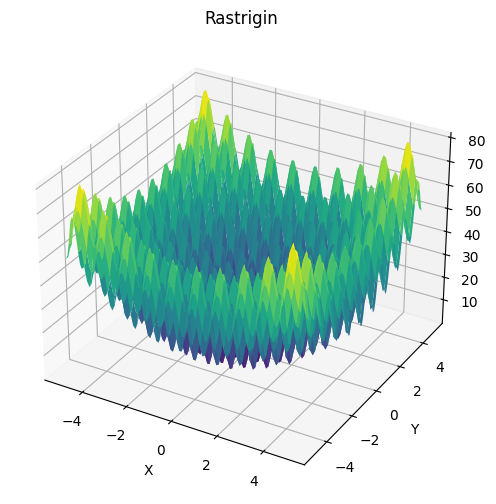

torch.Size([7984, 20, 2])
Epoch [1/500], Loss: 1415.4050
Epoch [2/500], Loss: 1394.9725
Epoch [3/500], Loss: 1375.7572
Epoch [4/500], Loss: 1354.9082
Epoch [5/500], Loss: 1330.3057
Epoch [6/500], Loss: 1297.5892
Epoch [7/500], Loss: 1258.0872
Epoch [8/500], Loss: 1226.9305
Epoch [9/500], Loss: 1200.5299
Epoch [10/500], Loss: 1176.5719
Epoch [11/500], Loss: 1153.8182
Epoch [12/500], Loss: 1131.6312
Epoch [13/500], Loss: 1109.7710
Epoch [14/500], Loss: 1088.1832
Epoch [15/500], Loss: 1066.8524
Epoch [16/500], Loss: 1045.7701
Epoch [17/500], Loss: 1024.9459
Epoch [18/500], Loss: 1004.3907
Epoch [19/500], Loss: 984.0967
Epoch [20/500], Loss: 964.0405
Epoch [21/500], Loss: 944.2137
Epoch [22/500], Loss: 924.6454
Epoch [23/500], Loss: 905.3916
Epoch [24/500], Loss: 886.4988
Epoch [25/500], Loss: 867.9786
Epoch [26/500], Loss: 849.8165
Epoch [27/500], Loss: 831.9933
Epoch [28/500], Loss: 814.4967
Epoch [29/500], Loss: 797.3214
Epoch [30/500], Loss: 780.4666
Epoch [31/500], Loss: 763.9332
Epoc

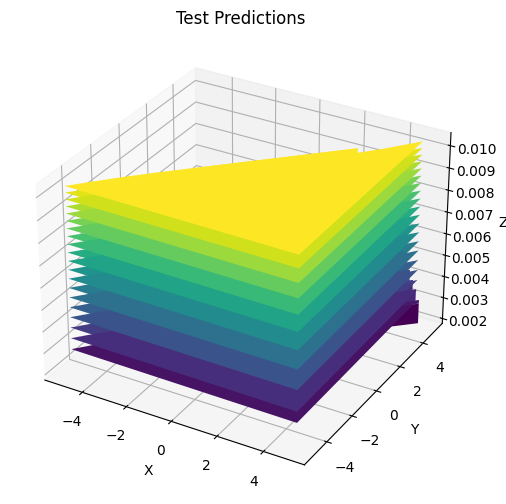

In [184]:
X_ras, Y_ras, Z_ras = rastrigin_3d()
plot_func_3D(X_ras, Y_ras, Z_ras, "Rastrigin")

X_train_RNN_ras_3d, X_test_RNN_ras_3d, y_train_RNN_ras_3d, y_test_RNN_ras_3d = prepare_datasets_2D(X_ras, Y_ras, Z_ras, "RNN", sequence_length=16)
X_train_CNN_ras_3d, X_test_CNN_ras_3d, y_train_CNN_ras_3d, y_test_CNN_ras_3d = prepare_datasets_2D(X_ras, Y_ras, Z_ras, "CNN", sequence_length=20)

model_RNN_ras_3d = SimpleRNN(input_size=2, hidden_size=32, output_size=1)
criterion_RNN_ras_3d = nn.MSELoss()
optimizer_RNN_ras_3d = torch.optim.Adam(model_RNN_ras_3d.parameters(), lr=0.01)
print(X_train_CNN_ras_3d.shape)
training_n_evaluation_3D("RNN", 500, model_RNN_ras_3d, criterion_RNN_ras_3d, optimizer_RNN_ras_3d, X_train_RNN_ras_3d, X_test_RNN_ras_3d, y_train_RNN_ras_3d, y_test_RNN_ras_3d)


# NOTE: NOT WORKING PROPERLY
# model_CNN_ras_3d = SimpleCNN(sequence_length=20, input_size=2)
# criterion_CNN_ras_3d = nn.MSELoss()
# optimizer_CNN_ras_3d = torch.optim.Adam(model_CNN_ras_3d.parameters(), lr=0.1)
# training_n_evaluation("CNN", 250, model_CNN_ras_3d, criterion_CNN_ras_3d, optimizer_CNN_ras_3d, X_train_CNN_ras_3d, X_test_CNN_ras_3d, y_train_CNN_ras_3d, y_test_CNN_ras_3d)

auckley

In [185]:
def ackley_3d():
    x_values = np.linspace(-5, 5, 100)
    y_values = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x_values, y_values)
    Z = -20 * np.exp(-0.2 * np.sqrt(0.5*(X**2 + Y**2))) - np.exp(0.5*(np.cos(2*np.pi*X) + np.cos(2*np.pi*Y))) + 20 + np.e
    return X, Y, Z

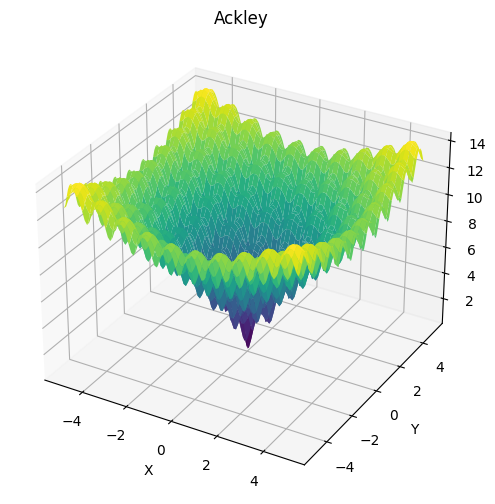

Epoch [1/600], Loss: 94.9533
Epoch [2/600], Loss: 90.3036
Epoch [3/600], Loss: 86.0964
Epoch [4/600], Loss: 81.0892
Epoch [5/600], Loss: 74.4969
Epoch [6/600], Loss: 66.0995
Epoch [7/600], Loss: 56.5316
Epoch [8/600], Loss: 48.3195
Epoch [9/600], Loss: 42.2076
Epoch [10/600], Loss: 37.4302
Epoch [11/600], Loss: 33.4226
Epoch [12/600], Loss: 29.8836
Epoch [13/600], Loss: 26.6741
Epoch [14/600], Loss: 23.7398
Epoch [15/600], Loss: 21.0652
Epoch [16/600], Loss: 18.6473
Epoch [17/600], Loss: 16.4834
Epoch [18/600], Loss: 14.5678
Epoch [19/600], Loss: 12.8920
Epoch [20/600], Loss: 11.4464
Epoch [21/600], Loss: 10.2198
Epoch [22/600], Loss: 9.2003
Epoch [23/600], Loss: 8.3747
Epoch [24/600], Loss: 7.7282
Epoch [25/600], Loss: 7.2445
Epoch [26/600], Loss: 6.9056
Epoch [27/600], Loss: 6.6926
Epoch [28/600], Loss: 6.5854
Epoch [29/600], Loss: 6.5642
Epoch [30/600], Loss: 6.6091
Epoch [31/600], Loss: 6.7012
Epoch [32/600], Loss: 6.8233
Epoch [33/600], Loss: 6.9597
Epoch [34/600], Loss: 7.0973
Ep

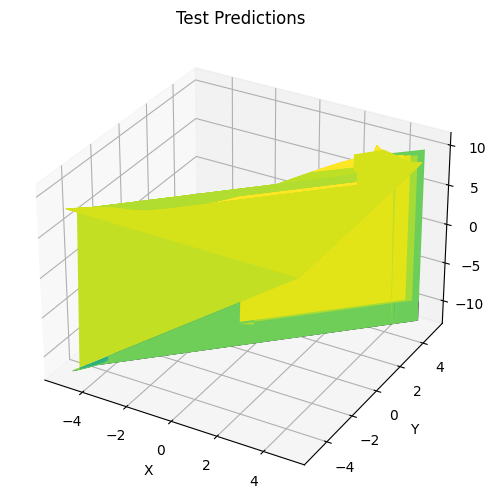

In [188]:
X_ack, Y_ack, Z_ack = ackley_3d()
plot_func_3D(X_ack, Y_ack, Z_ack, "Ackley")

X_train_RNN_ack_3d, X_test_RNN_ack_3d, y_train_RNN_ack_3d, y_test_RNN_ack_3d = prepare_datasets_2D(X_ack, Y_ack, Z_ack, "RNN", sequence_length=16)

model_RNN_ack_3d = SimpleRNN(input_size=2, hidden_size=32, output_size=1)
criterion_RNN_ack_3d = nn.MSELoss()
optimizer_RNN_ack_3d = torch.optim.Adam(model_RNN_ack_3d.parameters(), lr=0.01)
training_n_evaluation_3D("RNN", 600, model_RNN_ack_3d, criterion_RNN_ack_3d, optimizer_RNN_ack_3d, X_train_RNN_ack_3d, X_test_RNN_ack_3d, y_train_RNN_ack_3d, y_test_RNN_ack_3d)

rosenbrock

In [190]:
def rosenbrock_3d():
    x_values = np.linspace(-5, 5, 100)
    y_values = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x_values, y_values)
    Z = 100 * (Y - X**2)**2 + (1 - X)**2
    return X, Y, Z

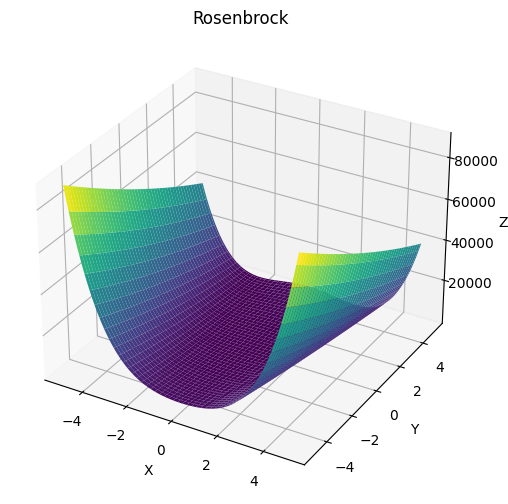

Epoch [1/200], Loss: 618376768.0000
Epoch [2/200], Loss: 618333248.0000
Epoch [3/200], Loss: 618207296.0000
Epoch [4/200], Loss: 618056768.0000
Epoch [5/200], Loss: 617922624.0000
Epoch [6/200], Loss: 617783296.0000
Epoch [7/200], Loss: 617633280.0000
Epoch [8/200], Loss: 617481216.0000
Epoch [9/200], Loss: 617325120.0000
Epoch [10/200], Loss: 617167168.0000
Epoch [11/200], Loss: 616997952.0000
Epoch [12/200], Loss: 616831872.0000
Epoch [13/200], Loss: 616663936.0000
Epoch [14/200], Loss: 616458048.0000
Epoch [15/200], Loss: 616149056.0000
Epoch [16/200], Loss: 615891712.0000
Epoch [17/200], Loss: 615711744.0000
Epoch [18/200], Loss: 615605568.0000
Epoch [19/200], Loss: 615456320.0000
Epoch [20/200], Loss: 615082624.0000
Epoch [21/200], Loss: 614755008.0000
Epoch [22/200], Loss: 614519104.0000
Epoch [23/200], Loss: 614301184.0000
Epoch [24/200], Loss: 614091328.0000
Epoch [25/200], Loss: 613879872.0000
Epoch [26/200], Loss: 613668224.0000
Epoch [27/200], Loss: 613456320.0000
Epoch [28/

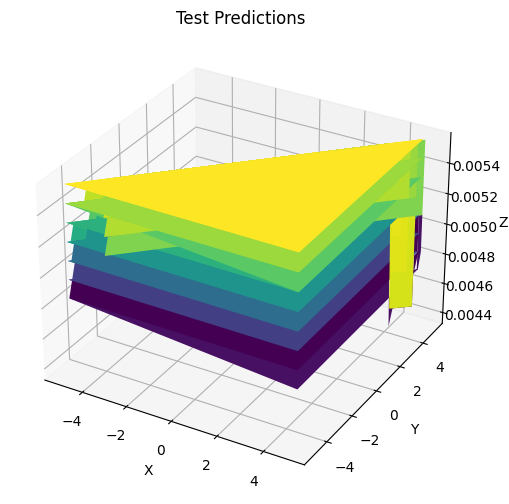

In [191]:
X_rosen, Y_rosen, Z_rosen = rosenbrock_3d()
plot_func_3D(X_rosen, Y_rosen, Z_rosen, "Rosenbrock")

X_train_RNN_rosen_3d, X_test_RNN_rosen_3d, y_train_RNN_rosen_3d, y_test_RNN_rosen_3d = prepare_datasets_2D(X_rosen, Y_rosen, Z_rosen, "RNN", sequence_length=12)

model_RNN_rosen_3d = SimpleRNN(input_size=2, hidden_size=64, output_size=1)
criterion_RNN_rosen_3d = nn.MSELoss()
optimizer_RNN_rosen_3d = torch.optim.Adam(model_RNN_rosen_3d.parameters(), lr=0.1)
training_n_evaluation_3D("RNN", 200, model_RNN_rosen_3d, criterion_RNN_rosen_3d, optimizer_RNN_rosen_3d, X_train_RNN_rosen_3d, X_test_RNN_rosen_3d, y_train_RNN_rosen_3d, y_test_RNN_rosen_3d)

PODSUMOWANIE

W sprawie eksperymentu 1 i 2 to widać że zdecydowanie lepsze wyniki uzyskiwane są dla sieci Conv1D niż klasycznych rekurencyjnych.  Bardzo dobrze wypadają sieci rekurencyjne w odmianie LSTM lub GRU, ponieważ rozwiązują one zjawisko zanikającego gradientu, charakterystynego dla klasycznych RNN. Raczej sieci konwolucyjne dla bardziej złożonych lub dłuższych sekwencji powinny wypaść gorzej od GRU lub LSTM. Konwolucja nie jest dobra do modelowania złożonych szeregów czasowych. Myślę że konwolucja wypadła lepiej tylko i wyłącznie dlatego że jest odporna na zanik gradientu, a przynajmniej bardziej niż RNN. Wyniki wyszły poprawnie dla wszystkich modeli i sieci dla eksperymentu 1 i 2, poza Rosenbrockiem w wydaniu RNN - myślę że nieliniowość funkcji Rosenbrocka pogłębia problem zanikającego gradientu.
Niestety ale eksperyment 3 nie do końca się udał. Sieć CNN dla tego eksperymentu, nie ulegała wykonaniu przez intepreter z uwagi na dość dziwne błędy, których nie udało mi się naprawić. Zaś wyniki dla sieci RNN są słabe, myśle że to może wynikać z faktu, że gdzieś po drodze, dane zostały źle przekształcone, ale nie udało mi się teog wyłapać. Aczkolwiek nie spodziewałbym się i tak imponujących rezultatów z RNN. Możliwe że bardziej skomplikowana sieć CNN by sobie poradziła, a raczej napewno, ale niestety nie zdążyłem dokończyć tego, tak aby działało - dlatego pozostawiłem zakomentowany fragment dla Rastringa. Natomiast w kwestii tak skomplikowanych funkcji oprócz funkcji CNN, dopatrywałbym się wykorzystania już wspomnianych LSTM/GRU, lub też sieci typu GAN (Generative Adversarial Networks), lub połączenia sieci w twór rekurencyjno-konwolucyjny (RCNN).
Za implementacje sieci LSTM lub GRU się nie brałem z uwagi na to że będą one przedmiotem kolejnych zajęć, ponad to bardzo dużo czasu wykorzystałem na próbę naprawy CNN.


III Poprawiony:

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Definicja Simple RNN
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def prepare_data(seq_len, total_samples, begin, end, func):
  t = np.linspace(begin, end, total_samples)

  values = func(t)

  X = []
  y = []
  for i in range(len(values) - seq_len):
      X.append(values[i:i+seq_len])
      y.append(values[i+seq_len])
  # Konwersja na tensory PyTorch
  X = torch.tensor(X).unsqueeze(2).float()
  y = torch.tensor(y).unsqueeze(1).float()

  split = int(0.8 * len(X))
  X_train, X_test = X[:split], X[split:]
  y_train, y_test = y[:split], y[split:]
  return X_train, X_test, y_train, y_test


In [ ]:
def train(model, x, y, criterion, optimizer):
  model.train()
  outputs = model(x)
  loss = criterion(outputs, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
class CNN(nn.Module):
    def __init__(self, sequence_len):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * sequence_len, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def rastrigin_2d(x, y):
    return 20 + (x**2 - 10 * np.cos(2*np.pi*x)) + (y**2 - 10 * np.cos(2*np.pi*y))

def ackley_2d(x, y):
    return -20 * np.exp(-0.2 * np.sqrt(0.5*(x**2 + y**2))) - np.exp(0.5*(np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) + 20 + np.e

def booth_2d(x, y):
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2


In [ ]:
def prepare_data_2d(seq_len, total_samples, begin, end, func):
    x = np.linspace(begin, end, int(np.sqrt(total_samples)))
    y = np.linspace(begin, end, int(np.sqrt(total_samples)))
    X_grid, Y_grid = np.meshgrid(x, y)

    Z_values = func(X_grid, Y_grid).flatten()
    X, y = [], []
    flat_X_grid = X_grid.flatten()
    flat_Y_grid = Y_grid.flatten()
    for i in range(len(Z_values) - seq_len):
        X_seq, Y_seq = flat_X_grid[i:i+seq_len], flat_Y_grid[i:i+seq_len]
        XY_seq = np.stack((X_seq, Y_seq), axis=1)
        X.append(XY_seq)
        y.append(Z_values[i+seq_len])

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, X_test, y_train, y_test


In [ ]:
functions = {"ackley_2d": ackley_2d}

seq_len = 50
total_samples = 5000
hidden_size = 32
input_size = 2
output_size = 1

cmap = plt.colormaps['Set1']

plt.figure(figsize=(25, 15))
for i, (name, function) in enumerate(functions.items()):
  X_train, X_test, y_train, y_test = prepare_data_2d(
      seq_len=seq_len, total_samples=total_samples, begin=-10, end=10, func=function)
  model_rnn = SimpleRNN(input_size, hidden_size, output_size).to(DEVICE)
  criterion = nn.MSELoss()
  optimizer_rnn = torch.optim.RMSprop(model_rnn.parameters(), lr=0.01)

  model_cnn = CNN(sequence_len=seq_len, in_channels=2).to(DEVICE)
  optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.01)

  num_epochs = 1000
  for epoch in range(num_epochs):
      loss_rnn = train(model_rnn, X_train.to(DEVICE), y_train.to(DEVICE), criterion, optimizer_rnn)
      loss_cnn = train(model_cnn, X_train.transpose(1, 2).to(DEVICE), y_train.to(DEVICE), criterion, optimizer_cnn)

      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss RNN: {loss_rnn.item():.4f}, Loss CNN: {loss_cnn.item():.4f}')

  model_rnn.eval()
  with torch.no_grad():
      predictions_rnn = model_rnn(X_test.to(DEVICE))

  model_cnn.eval()
  with torch.no_grad():
      predictions_cnn = model_cnn(X_test.transpose(1, 2).to(DEVICE))

  predictions_rnn = predictions_rnn.cpu().numpy()
  predictions_cnn = predictions_cnn.cpu().numpy()
  actual = y_test.cpu().numpy()

  fig = plt.figure(figsize=(20, 10))
  ax1 = fig.add_subplot(131, projection='3d')
  ax1.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), actual, color='r', label='Actual')
  ax1.set_title("Actual Values")
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.set_zlabel('Z')
  ax1.legend()
  ax2 = fig.add_subplot(132, projection='3d')
  ax2.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), predictions_rnn, color='b', label='Predictions RNN')
  ax2.set_title("Predictions RNN")
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_zlabel('Z')
  ax2.legend()
  ax3 = fig.add_subplot(133, projection='3d')
  ax3.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), predictions_cnn, color='b', label='Predictions CNN')
  ax3.set_title("Predictions CNN")
  ax3.set_xlabel('X')
  ax3.set_ylabel('Y')
  ax3.set_zlabel('Z')
  ax3.legend()

plt.show()


plt.show()

In [ ]:
functions = {"rastrigin_2d": rastrigin_2d}

seq_len = 50
total_samples = 5000
hidden_size = 128
input_size = 2
output_size = 1

cmap = plt.colormaps['Set1']

plt.figure(figsize=(25, 15))
for i, (name, function) in enumerate(functions.items()):
  X_train, X_test, y_train, y_test = prepare_data_2d(
      seq_len=seq_len, total_samples=total_samples, begin=-10, end=10, func=function)
  model_rnn = SimpleRNN(input_size, hidden_size, output_size).to(DEVICE)
  criterion = nn.MSELoss()
  optimizer_rnn = torch.optim.RMSprop(model_rnn.parameters(), lr=0.01)

  model_cnn = CNN(sequence_len=seq_len, in_channels=2).to(DEVICE)
  optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.01)

  num_epochs = 1000
  for epoch in range(num_epochs):
      loss_rnn = train(model_rnn, X_train.to(DEVICE), y_train.to(DEVICE), criterion, optimizer_rnn)
      loss_cnn = train(model_cnn, X_train.transpose(1, 2).to(DEVICE), y_train.to(DEVICE), criterion, optimizer_cnn)

      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss RNN: {loss_rnn.item():.4f}, Loss CNN: {loss_cnn.item():.4f}')

  model_rnn.eval()
  with torch.no_grad():
      predictions_rnn = model_rnn(X_test.to(DEVICE))

  model_cnn.eval()
  with torch.no_grad():
      predictions_cnn = model_cnn(X_test.transpose(1, 2).to(DEVICE))

  predictions_rnn = predictions_rnn.cpu().numpy()
  predictions_cnn = predictions_cnn.cpu().numpy()
  actual = y_test.cpu().numpy()

  fig = plt.figure(figsize=(20, 10))
  ax1 = fig.add_subplot(131, projection='3d')
  ax1.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), actual, color='r', label='Actual')
  ax1.set_title("Actual Values")
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.set_zlabel('Z')
  ax1.legend()
  ax2 = fig.add_subplot(132, projection='3d')
  ax2.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), predictions_rnn, color='b', label='Predictions RNN')
  ax2.set_title("Predictions RNN")
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_zlabel('Z')
  ax2.legend()
  ax3 = fig.add_subplot(133, projection='3d')
  ax3.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), predictions_cnn, color='b', label='Predictions CNN')
  ax3.set_title("Predictions CNN")
  ax3.set_xlabel('X')
  ax3.set_ylabel('Y')
  ax3.set_zlabel('Z')
  ax3.legend()

plt.show()


plt.show()

In [ ]:
functions = {"booth_2d": booth_2d}

seq_len = 500
total_samples = 5000
hidden_size = 128
input_size = 2
output_size = 1

cmap = plt.colormaps['Set1']

plt.figure(figsize=(25, 15))
for i, (name, function) in enumerate(functions.items()):
  X_train, X_test, y_train, y_test = prepare_data_2d(
      seq_len=seq_len, total_samples=total_samples, begin=-10, end=10, func=function)
  model_rnn = SimpleRNN(input_size, hidden_size, output_size).to(DEVICE)
  criterion = nn.MSELoss()
  optimizer_rnn = torch.optim.RMSprop(model_rnn.parameters(), lr=0.01)

  model_cnn = CNN(sequence_len=seq_len, in_channels=2).to(DEVICE)
  optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.01)

  num_epochs = 1000
  for epoch in range(num_epochs):
      loss_rnn = train(model_rnn, X_train.to(DEVICE), y_train.to(DEVICE), criterion, optimizer_rnn)
      loss_cnn = train(model_cnn, X_train.transpose(1, 2).to(DEVICE), y_train.to(DEVICE), criterion, optimizer_cnn)

      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss RNN: {loss_rnn.item():.4f}, Loss CNN: {loss_cnn.item():.4f}')

  model_rnn.eval()
  with torch.no_grad():
      predictions_rnn = model_rnn(X_test.to(DEVICE))

  model_cnn.eval()
  with torch.no_grad():
      predictions_cnn = model_cnn(X_test.transpose(1, 2).to(DEVICE))

  predictions_rnn = predictions_rnn.cpu().numpy()
  predictions_cnn = predictions_cnn.cpu().numpy()
  actual = y_test.cpu().numpy()

  fig = plt.figure(figsize=(20, 10))
  ax1 = fig.add_subplot(131, projection='3d')
  ax1.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), actual, color='r', label='Actual')
  ax1.set_title("Actual Values")
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.set_zlabel('Z')
  ax1.legend()
  ax2 = fig.add_subplot(132, projection='3d')
  ax2.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), predictions_rnn, color='b', label='Predictions RNN')
  ax2.set_title("Predictions RNN")
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_zlabel('Z')
  ax2.legend()
  ax3 = fig.add_subplot(133, projection='3d')
  ax3.scatter(X_test[:, 0, 0].cpu().numpy(), X_test[:, 0, 1].cpu().numpy(), predictions_cnn, color='b', label='Predictions CNN')
  ax3.set_title("Predictions CNN")
  ax3.set_xlabel('X')
  ax3.set_ylabel('Y')
  ax3.set_zlabel('Z')
  ax3.legend()

plt.show()


plt.show()